In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

2025-05-11 10:43:26.047003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746960206.220599      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746960206.272563      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_folder =  f"{dataset_path}/Image"
mask_folder = f"{dataset_path}/Mask"
if os.path.exists(image_folder) and os.path.exists(mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

In [3]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_folder, mask_folder, batch_size=1, img_size=(256, 256)):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))
    
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[k] for k in indexes]
        batch_masks = [self.mask_filenames[k] for k in indexes]
        images, masks = self.__load_batch(batch_images, batch_masks)
        return images, masks
    
    def __load_batch(self, batch_images, batch_masks):
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = load_img(os.path.join(self.image_folder, img_file), target_size=self.img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(os.path.join(self.mask_folder, mask_file), target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)

In [4]:
from sklearn.model_selection import train_test_split


train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.33, random_state=42
)

train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)
test_generator = DataGenerator(test_images, test_masks, image_folder, mask_folder, batch_size=1)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 231 images
Validation set: 38 images
Test set: 20 images


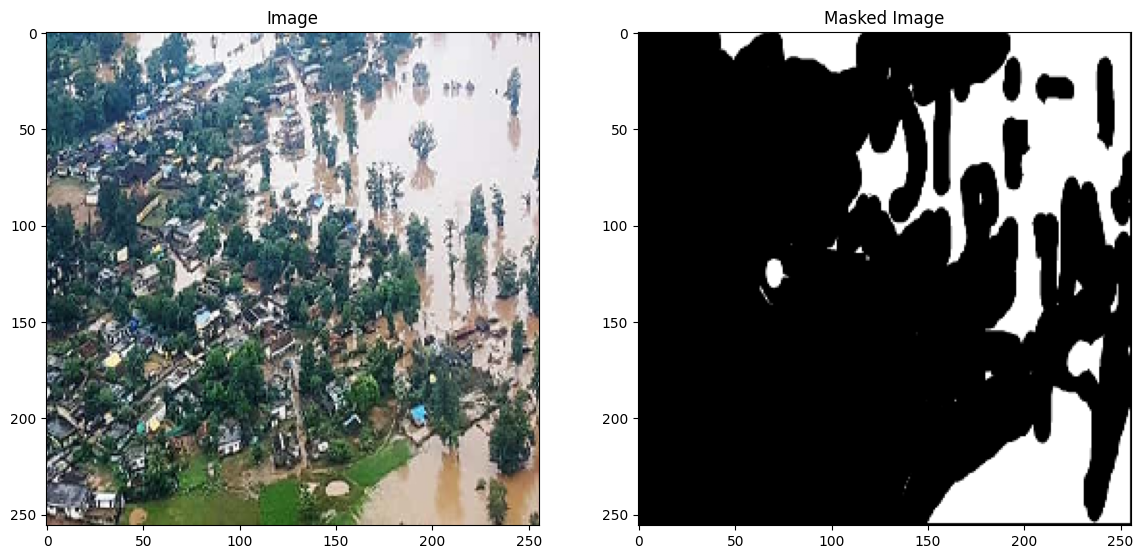

In [5]:
random_image_id = random.randint(0, len(train_generator) - 1)
sample_image, sample_mask = train_generator[random_image_id]

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(sample_image[0])  
plt.title("Image")

plt.subplot(122)
plt.imshow(sample_mask[0].squeeze(), cmap='gray') 
plt.title("Masked Image")
plt.show()

In [6]:
def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):

    inputs = Input(input_shape)
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    b = residual_block(s3, 512, strides=2)

    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs, outputs, name="RESUNET")

    return model

In [7]:

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

I0000 00:00:1746960218.842966      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746960218.843673      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
input_shape = (256, 256, 3)
model = build_resunet(input_shape)
model.compile(optimizer="adam",
              loss=combined_loss,
              metrics=["accuracy", dice_coefficient, f1_score, mean_iou, precision, recall])

In [9]:
model_history=model.fit(train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746960237.970552      98 service.cc:148] XLA service 0x7a7cc4003f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746960237.971251      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746960237.971273      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746960239.456085      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746960245.406308      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

  1/231 ━━━━━━━━━━━━━━━━━━━━ 2:15:48 35s/step - accuracy: 0.5492 - dice_coefficient: 0.5950 - f1_score: 0.6051 - loss: 0.6401 - mean_iou: 0.2289 - precision: 0.5971 - recall: 0.6133

I0000 00:00:1746960255.836739      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 ━━━━━━━━━━━━━━━━━━━━ 58s 97ms/step - accuracy: 0.7458 - dice_coefficient: 0.6151 - f1_score: 0.6426 - loss: 0.9479 - mean_iou: 0.3484 - precision: 0.6776 - recall: 0.6924 - val_accuracy: 0.4530 - val_dice_coefficient: 0.5740 - val_f1_score: 0.6422 - val_loss: 0.6830 - val_mean_iou: 0.3018 - val_precision: 0.4530 - val_recall: 0.9958
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.7949 - dice_coefficient: 0.7023 - f1_score: 0.7767 - loss: 0.4483 - mean_iou: 0.2978 - precision: 0.7673 - recall: 0.7796 - val_accuracy: 0.7712 - val_dice_coefficient: 0.6198 - val_f1_score: 0.7435 - val_loss: 0.4678 - val_mean_iou: 0.2765 - val_precision: 0.7753 - val_recall: 0.6977
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.8007 - dice_coefficient: 0.6729 - f1_score: 0.7336 - loss: 0.4254 - mean_iou: 0.2613 - precision: 0.7565 - recall: 0.7560 - val_accuracy: 0.7951 - val_dice_coefficient: 0.6868 - val_f1_score: 0.7837 - val_loss: 0.4059 - val_mean_iou:

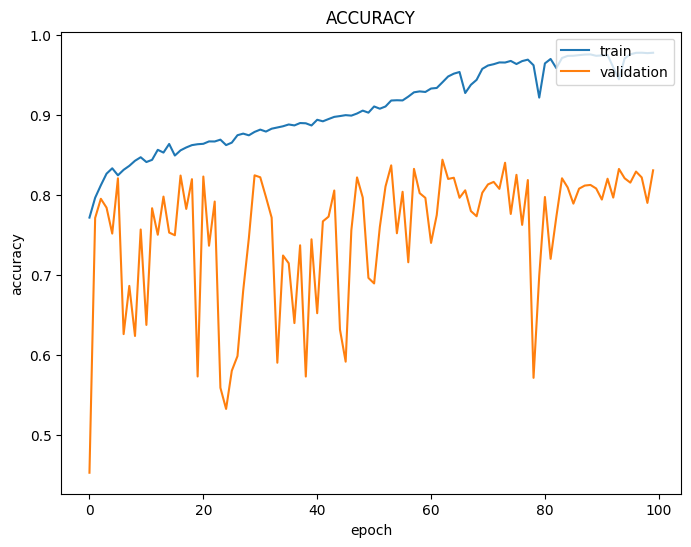

In [10]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

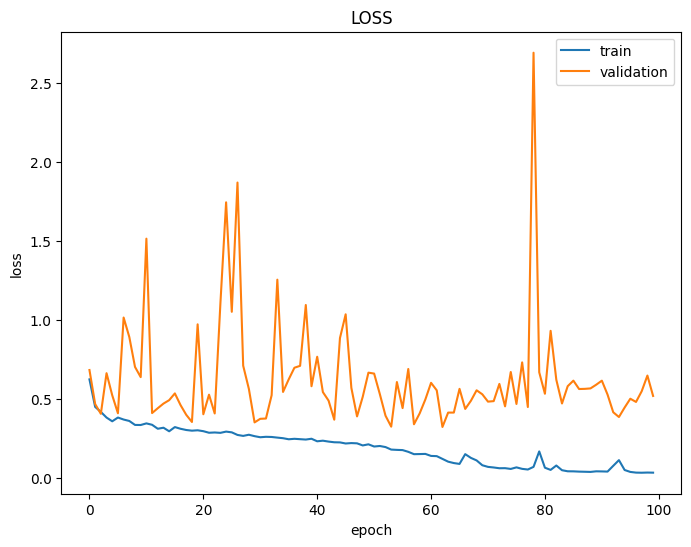

In [11]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

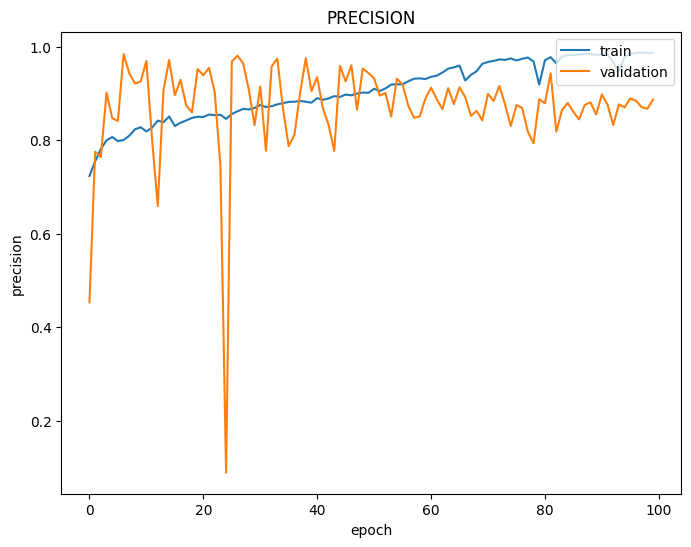

In [12]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision'])
ax13.plot(model_history.history['val_precision'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')

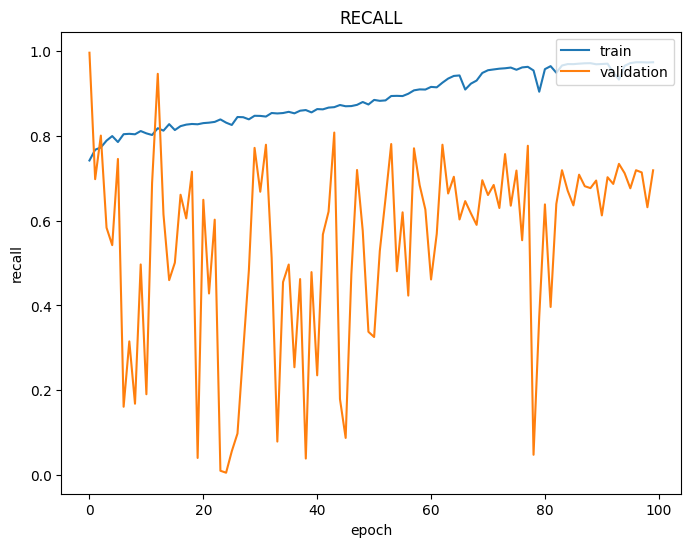

In [13]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall'])
ax14.plot(model_history.history['val_recall'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

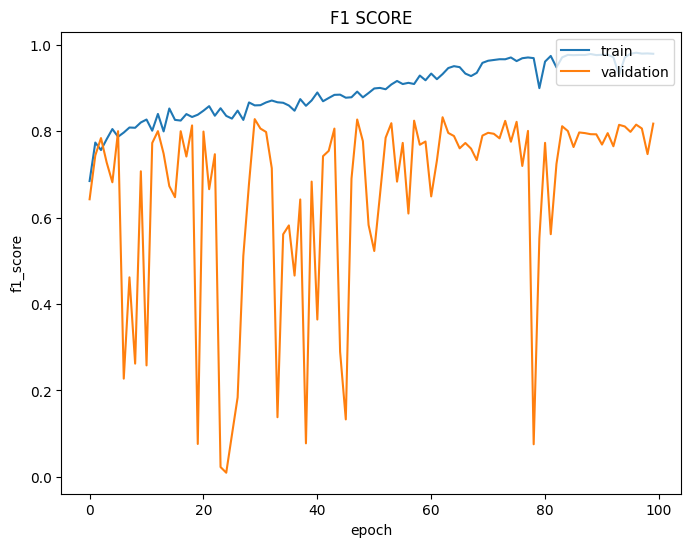

In [14]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

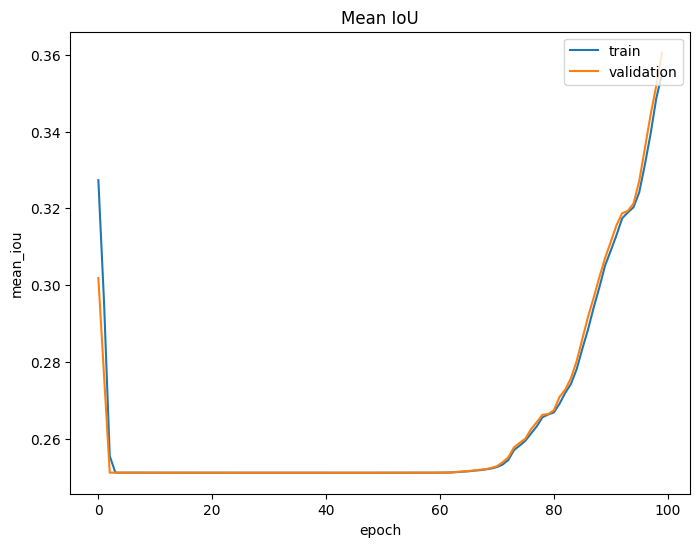

In [15]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

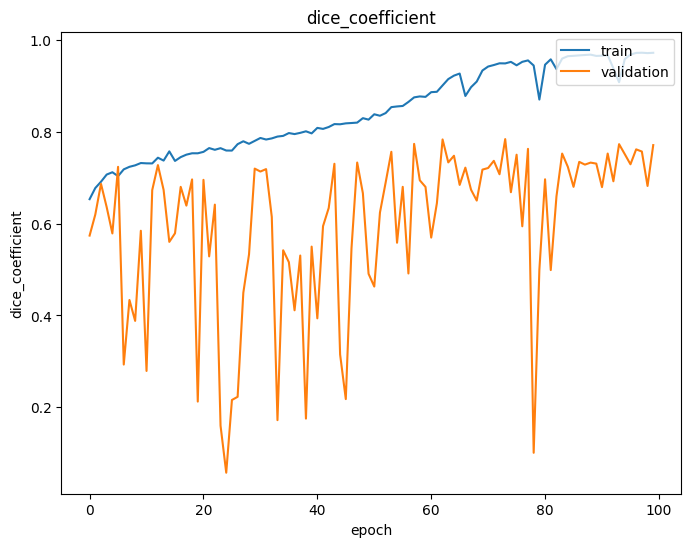

In [16]:
fig,ax17=plt.subplots(figsize=(8,6))
ax17.plot(model_history.history['dice_coefficient'])
ax17.plot(model_history.history['val_dice_coefficient'])
ax17.title.set_text('dice_coefficient')
ax17.set_ylabel('dice_coefficient')
ax17.set_xlabel('epoch')
ax17.legend(['train', 'validation'], loc='upper right')

In [17]:
pred_masks = model.predict(test_generator)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [18]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8908 - dice_coefficient: 0.8362 - f1_score: 0.8958 - loss: 0.3273 - mean_iou: 0.3606 - precision: 0.9012 - recall: 0.8558
Test Loss: 0.3643
dice coefficient: 0.8904
Test Accuracy: 0.7928
Test F1 Score: 0.8803
Test Precision: 0.3606
Test Recall: 0.8823
Test MeanIoU: 0.8220


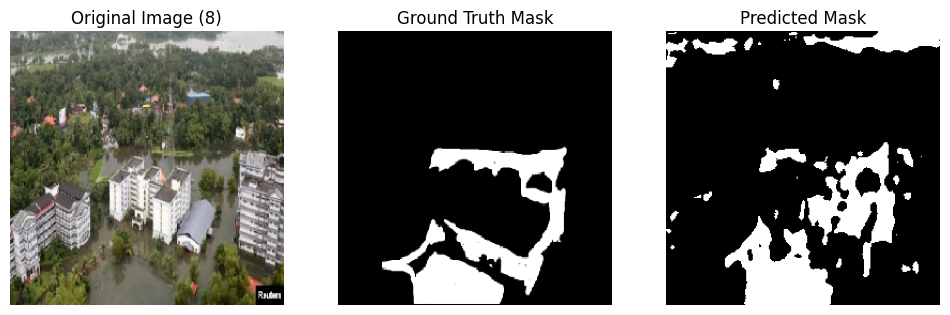

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_prediction(test_generator, pred_masks):
    idx = random.randint(0, len(test_generator) - 1)

    test_image, test_mask = test_generator[idx]  

    
    test_image = test_image[0]  
    test_mask = test_mask[0].squeeze() 
    pred_mask = pred_masks[idx].squeeze()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


visualize_random_prediction(test_generator, pred_masks)